In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import pywt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, confusion_matrix, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

Using 2 GPUs


In [4]:
train_df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
submission = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv')

spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy',allow_pickle=True)

In [5]:
display(train_df.head())
display(test_df.head())

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [6]:
train_votes = train_df.columns[-6:]

train = train_df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds', 'patient_id' ,'expert_consensus']].agg(
    {'spectrogram_id': 'first',
     'spectrogram_label_offset_seconds': ['min', 'max'],
     'patient_id': 'first',
     'expert_consensus': 'first',
    })

train.columns = ['spec_id','spec_offset_min', 'spec_offset_max', 'patient_id', 'target']

tmp = train_df.groupby('eeg_id')[train_votes].agg('sum') # get sum per vote for each eeg
tmp[train_votes] = tmp[train_votes].div(tmp[train_votes].sum(axis=1), axis=0) # convert into probabilities

train[train_votes] = tmp
train = train[[col for col in train if col != 'target'] + ['target']] # put target variable at the end for more readability
train = train.reset_index()

display(train.head())

,eeg_id,spec_id,spec_offset_min,spec_offset_max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


## Denoising function

Can be useful later to generate spectrogram from EEG

In [11]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):
    ret = {key:[] for key in x.columns}
    
    for pos in x.columns:
        coeff = pywt.wavedec(x[pos], wavelet, mode="per")
        sigma = (1/0.6745) * maddest(coeff[-level])

        uthresh = sigma * np.sqrt(2*np.log(len(x)))
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

        ret[pos]=pywt.waverec(coeff, wavelet, mode='per')
    
    return pd.DataFrame(ret)

# eeg_denoised = denoise(eeg, wavelet="db8")

## Ploting function

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,2366870,0,0.0,1232582129,0,0.0,2855109799,23633,Other,0,1,0,0,0,2
1,2366870,1,14.0,1232582129,1,14.0,773276619,23633,Other,0,1,0,0,0,2
2,2366870,2,16.0,1232582129,2,16.0,92671217,23633,Other,0,1,0,0,0,2
3,2366870,3,22.0,1232582129,3,22.0,1537983433,23633,Other,0,1,0,0,0,2
4,2366870,4,28.0,1232582129,4,28.0,572370931,23633,Other,0,1,0,0,0,2
5,2366870,5,30.0,1232582129,5,30.0,1934783707,23633,Other,0,1,0,0,0,2


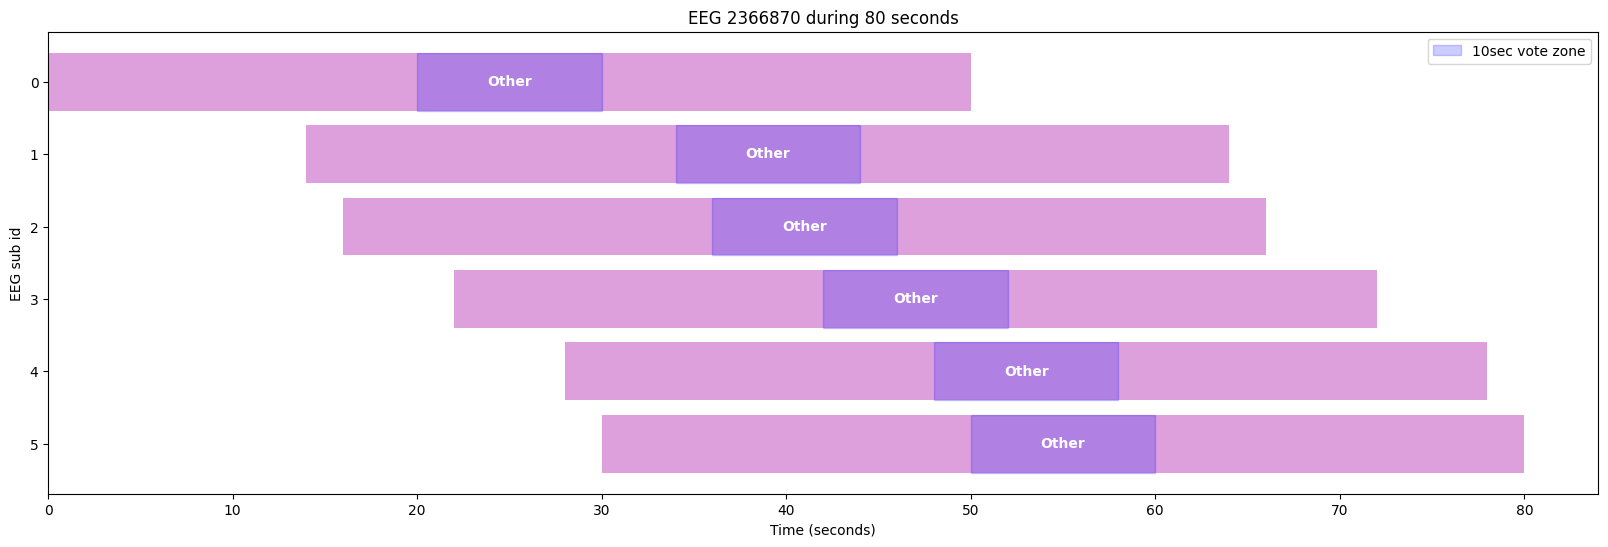

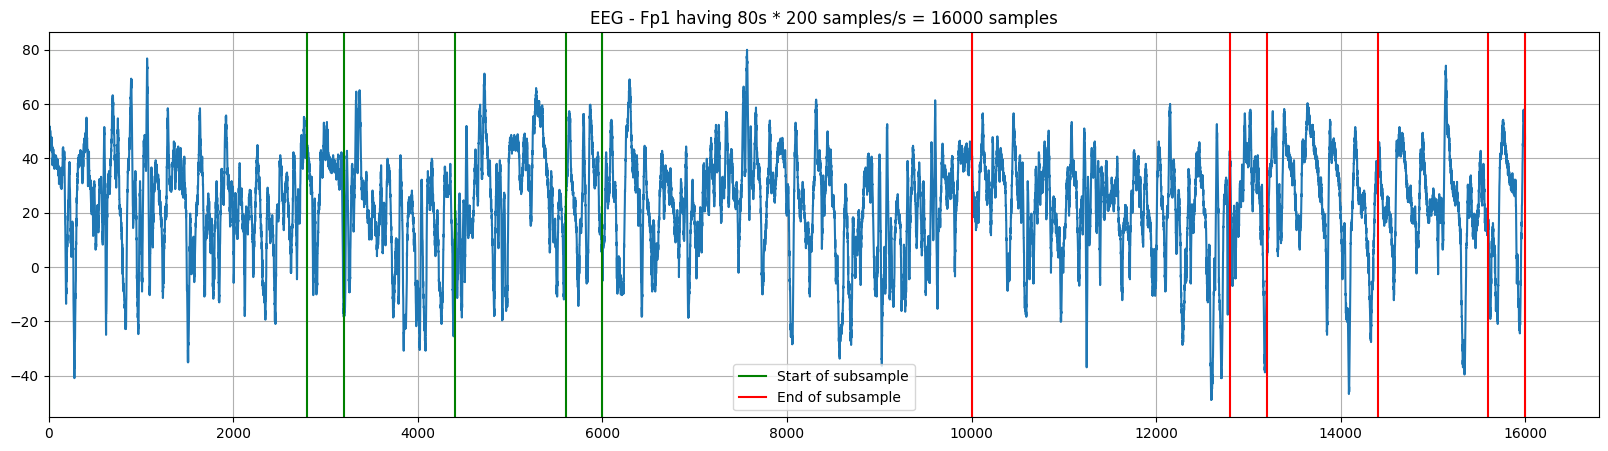

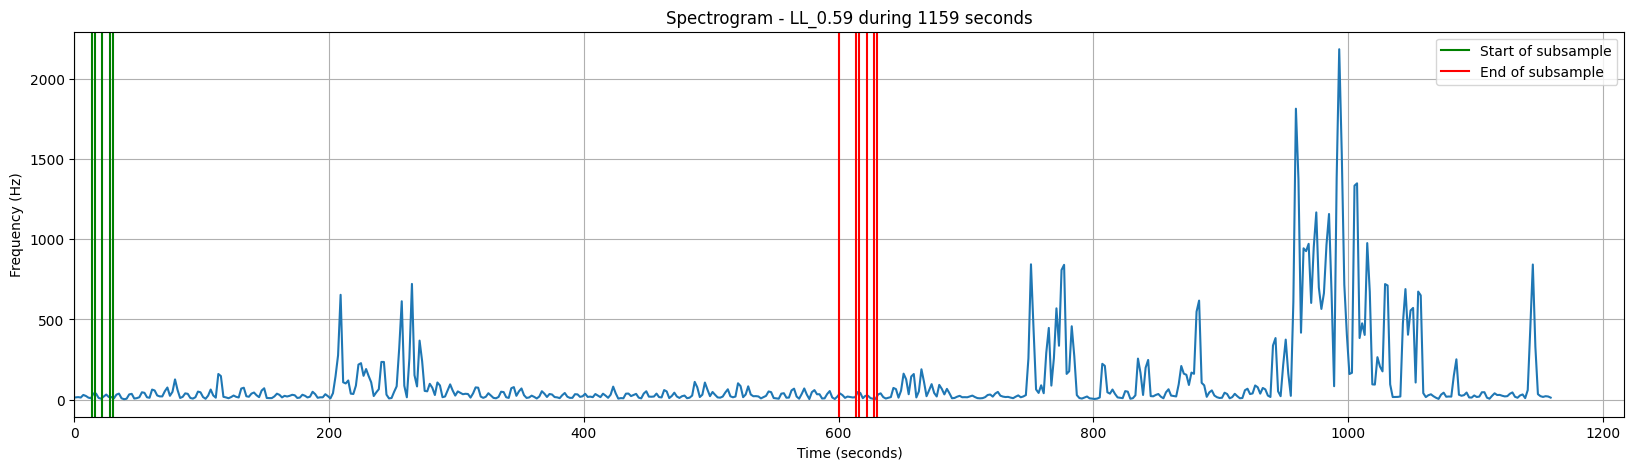

In [8]:
# 2366870, 2259539799
def eeg_info(eeg_id=36718960):
    eeg_df = train_df[train_df["eeg_id"] == eeg_id].reset_index(drop=True)
    spec = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/{eeg_df["spectrogram_id"].values[0]}.parquet')    

    eeg = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/{eeg_id}.parquet')
    
    display(eeg_df)
    
    # PLOT THE SUB EEG TIME REPRESENTATION
    plt.figure(figsize=(20, min(10, len(eeg_df))))
    bars = plt.barh(y=eeg_df['eeg_sub_id'], width=50, left=eeg_df['eeg_label_offset_seconds'], color='plum')
    
    y_min, y_max = plt.ylim()
    
    for i,row in eeg_df.iterrows():
        start_mid_range = row['eeg_label_offset_seconds'] + 50/2 - 5
        end_mid_range = row['eeg_label_offset_seconds'] + 50/2 + 5
        
        ymin, ymax = (y_max - 0.4 - i)/(abs(y_min) + y_max), (y_max + 0.4 - i)/(abs(y_min) + y_max)
        plt.axvspan(xmin=start_mid_range, xmax=end_mid_range, ymin=ymin, ymax=ymax, alpha=0.2, color='blue', label='10sec vote zone' if i == 0 else None)
        plt.text(25 + eeg_df['eeg_label_offset_seconds'].iloc[i], i+0.05, f'{eeg_df["expert_consensus"].iloc[i]}', color='white', fontweight='bold', horizontalalignment='center')
    
    
    plt.gca().invert_yaxis()
    plt.ylabel('EEG sub id')
    plt.xlabel('Time (seconds)')
    
    max_offset = int(eeg_df["eeg_label_offset_seconds"].max())
    eeg_time = max_offset + 50
                     
    plt.title(f'EEG {eeg_id} during {eeg_time} seconds')
    plt.legend()
    plt.show()
    
    
    # PLOT THE EEG VOTES 
    #display(eeg.head(3))
    
    plt.figure(figsize=(20,5))
    plt.plot(eeg['Fp1'])
    
    for i,row in eeg_df.iterrows():
        plt.axvline(x=(row['eeg_label_offset_seconds']*200),color='green', label='Start of subsample' if i == 0 else None)    
        plt.axvline(x=((row['eeg_label_offset_seconds']+50)*200),color='red', label='End of subsample' if i == 0 else None)  
    
    plt.title(f'EEG - Fp1 having {eeg_time}s * 200 samples/s = {eeg_time*200} samples')
    plt.xlim(xmin=0)
    plt.grid()
    plt.legend()
    plt.show()
    
    
    # PLOT THE SPECTROGRAM
    #display(spec.head(3))
               
    max_spec_offset = int(eeg_df['spectrogram_label_offset_seconds'].max())
    
    plt.figure(figsize=(20,5))
    plt.plot(spec['time'], spec['LL_0.59'])
    
    for i,row in eeg_df.iterrows():
        plt.axvline(x=row['spectrogram_label_offset_seconds'], color='green', label='Start of subsample' if i == 0 else None)   
        plt.axvline(x=((row['spectrogram_label_offset_seconds'])+600),color='red', label='End of subsample' if i == 0 else None)
    
    spec["time"]
    plt.title(f'Spectrogram - LL_0.59 during {spec["time"].values[-1]} seconds')
    plt.xlim(xmin=0)
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (seconds)')
    plt.legend()
    plt.grid()
    plt.show()

eeg_info(2366870)

**Some facts:**<br>
    - Experts vote on the 10 middle seconds of each sub EEG<br>
    - We have overlapping sub EEG<br>
    - Votes seems to be majoritarly unique between each sub EEG<br>
    - Expert consensus can be different in overlaping sub EEG during some seconds<br>

## Spectrogram working progress

#### The following code iterate through each row in train and preprocess 10 minutes of the corresponding spectrogram

In [13]:
channel_map = {0: "LL", 1: "LP", 2: "RR", 3: "RP"}
target_map = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}
i_target_map = {y:x for x,y in target_map.items()} # inverted target map

IMG_WIDTH = 256
IMG_HEIGHT = 128

X_spec = np.zeros((len(train), IMG_HEIGHT, IMG_WIDTH, 4), dtype='float32')
y_spec = np.zeros((len(train)), dtype='int8')


def plot_spectrogram(index):
    for channel in range(4):
        img = X_spec[index,:,:,channel]
        plt.figure(figsize=(10, 2))
        plt.imshow(img, aspect='auto', cmap='viridis', origin='lower')
        plt.xlabel('Time [sec]')
        plt.ylabel('Frequency [Hz]')
        plt.title(f'Spectrogram {train[index].spec_id} - {channel_map[channel]} : {i_target_map[y_spec[index]]}')
        plt.show()
        
def generate_spectrograms():
    for row in train.itertuples(): # for each row in train
        i = row[0] # get index of the row in train
        
        spec_id = row.spec_id
        spec = spectrograms.item()[spec_id]
        
        r = np.random.randint(row.spec_offset_min, row.spec_offset_max+1)//2

        for k in range(4): # 4 different channel (LL, LP, RR, RP)
            img = spec[r:r+300, k*100:(k+1)*100].T # get 10 random minutes of the spectrogram for each channel

            # log scaling
            img = np.clip(img, np.exp(-4), np.exp(8)) # avoid 0 for log
            img = np.log(img)

            # z-score scaling
            ep = 1e-6
            mean = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img - mean) / (std + ep)
            
            # convert nan to value 0
            img = np.nan_to_num(img, nan=0.0)

            # crop to size 256
            img = img[:,22:-22] # 300-22-22=256

            X_spec[i, 14:-14,:, k] = img # 14:-14 to put the IMG_HEIGHT (100) into 128
            y_spec[i] = target_map[row.target]
    
generate_spectrograms()

**Finally, we have 17 089 spectrograms, each one corresponding to an eeg_id**

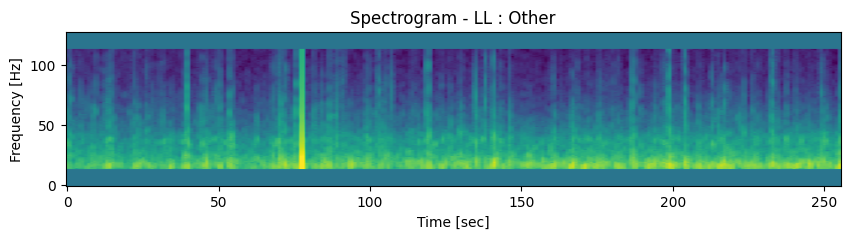

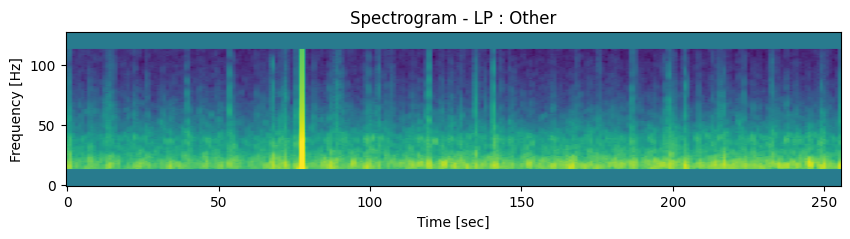

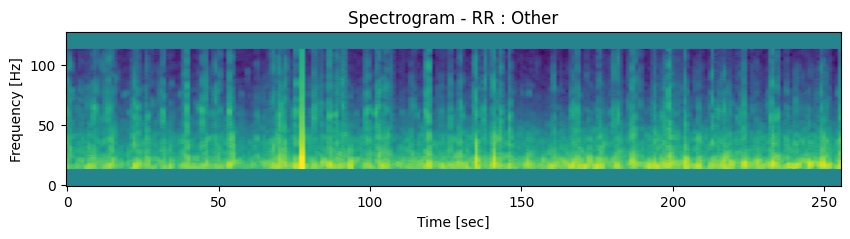

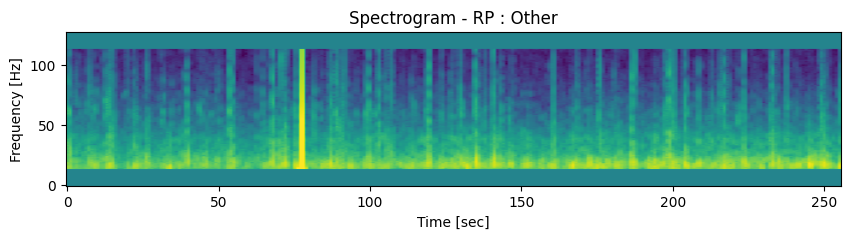

In [14]:
plot_spectrogram(0)

#### Now we will try to create the CNN model

In [16]:
def build_cnn_model(lr=1e-3): # impossible because to much RAM used
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128,256,4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=1))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=1))
    
    model.add(GlobalAveragePooling2D()) # avoid overfitting and because we have a lot of parameters per image
    
    model.add(Dense(len(set(y_spec)), activation='softmax', dtype='float32')) # to predict probability for each target class
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=lr), metrics=['KLDivergence'])
    
    return model

model = build_cnn_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 254, 32)      1184      
                                                                 
 batch_normalization_2 (Bat  (None, 126, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 125, 253, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 123, 251, 64)      18496     
                                                                 
 batch_normalization_3 (Bat  (None, 123, 251, 64)      256       
 chNormalization)                                                
                                                      

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_spec, y_spec, test_size=0.2, random_state=42, shuffle=False)

history = model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=0.2)

## EEG working progress

Create dataset for eeg

In [217]:
eeg_feature_df = []
for row in train.itertuples():
    eeg_id = row.eeg_id
    eeg_df = train_df[train_df["eeg_id"] == eeg_id].reset_index(drop=True)
    eeg = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/{eeg_id}.parquet')

    ranges = [(int(200 * offset + 4000), int(200 * offset + 6000)) for offset in eeg_df['eeg_label_offset_seconds']]
    filtered_eeg = pd.concat([eeg.iloc[s:e].mean().to_frame().T for s, e in ranges]).reset_index(drop=True)
    filtered_eeg['target'] = eeg_df['expert_consensus']
    filtered_eeg.insert(0, 'eeg_id', eeg_df['eeg_id'])
    filtered_eeg.insert(1, 'spec_id', eeg_df['spectrogram_id'])

    eeg_feature_df.append(filtered_eeg)
        
eeg_feature_df = pd.concat(eeg_feature_df).reset_index(drop=True)
display(eeg_feature_df)

,eeg_id,spec_id,Fp1,F3,C3,P3,F7,T3,T5,O1,...,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG,expert_consensus
0,568657,789577333,-69.936607,-32.804020,-7.905582,-43.257000,-61.127659,-31.424379,-69.502487,-47.520931,...,-10.686476,-3.706711,-55.657467,22.839092,-102.226173,45.509293,-44.362633,-23.080250,2999.501953,Other
1,568657,789577333,-95.123550,-47.845356,-3.902660,-48.335125,-67.061905,-50.688717,-77.635017,-59.724262,...,-19.867077,-1.378919,-62.598789,7.962570,-117.954384,43.980392,-53.327515,-24.513969,2979.069580,Other
2,568657,789577333,-97.947998,-61.715160,-12.471405,-35.971458,-72.810867,-46.678902,-79.694160,-48.629581,...,-28.590694,-13.187574,-64.031792,-11.590687,-111.976814,16.329615,-44.942970,-10.486493,2095.715820,Other
3,568657,789577333,-78.550667,-50.847717,-17.071093,-17.368683,-58.911903,-31.968685,-63.354355,-17.403872,...,-20.079378,-16.960184,-66.754501,7.324904,-84.176147,3.374494,-21.520885,30.822575,1367.206421,Other
4,582999,1552638400,-22.966063,-2.412256,5.876255,39.526047,-9.744861,-11.275120,-10.984276,-7.149900,...,6.905761,-7.191850,22.491468,-0.697435,-7.819445,8.228762,-17.959936,-10.444019,-8.559155,LPD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,4294858825,657299228,-398.256622,-381.371002,-334.381317,-330.806000,-381.168121,-330.685822,-357.933685,-337.865570,...,-314.545227,833.705688,-372.881073,-377.756622,-340.132629,-371.244324,-361.548553,-28.037125,17.132296,Other
106796,4294858825,657299228,-371.511414,-362.753693,-314.254883,-312.762817,-355.249390,-308.105682,-333.087372,-318.476257,...,-294.743500,754.718018,-351.074951,-356.915070,-321.833832,-348.428070,-339.828583,-23.964602,17.101355,Other
106797,4294858825,657299228,-359.607880,-352.819061,-304.547150,-306.067383,-342.398193,-299.119995,-322.675751,-308.811951,...,-287.970490,718.581360,-343.061310,-348.845184,-316.830444,-342.316162,-330.983368,-23.153782,17.103699,Other
106798,4294858825,657299228,-346.035065,-342.509644,-290.638611,-295.603241,-330.298157,-287.759735,-307.910370,-296.728851,...,-274.376465,657.276062,-325.006622,-331.525146,-304.209381,-325.394470,-313.865295,-20.501137,16.818390,Other


## Processing

In [237]:
eeg_feature_df = eeg_feature_df.drop(['eeg_id', 'spec_id'], axis=1)

le = LabelEncoder()
eeg_feature_df['expert_consensus'] = le.fit_transform(eeg_feature_df['expert_consensus'])

eeg_feature_df = eeg_feature_df.drop_duplicates()

display(eeg_feature_df)

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,...,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG,expert_consensus
0,-69.936607,-32.804020,-7.905582,-43.257000,-61.127659,-31.424379,-69.502487,-47.520931,-14.589449,-34.889587,...,-10.686476,-3.706711,-55.657467,22.839092,-102.226173,45.509293,-44.362633,-23.080250,2999.501953,4
1,-95.123550,-47.845356,-3.902660,-48.335125,-67.061905,-50.688717,-77.635017,-59.724262,-15.075439,-26.248478,...,-19.867077,-1.378919,-62.598789,7.962570,-117.954384,43.980392,-53.327515,-24.513969,2979.069580,4
2,-97.947998,-61.715160,-12.471405,-35.971458,-72.810867,-46.678902,-79.694160,-48.629581,-21.038746,-15.574305,...,-28.590694,-13.187574,-64.031792,-11.590687,-111.976814,16.329615,-44.942970,-10.486493,2095.715820,4
3,-78.550667,-50.847717,-17.071093,-17.368683,-58.911903,-31.968685,-63.354355,-17.403872,-18.162685,-26.363605,...,-20.079378,-16.960184,-66.754501,7.324904,-84.176147,3.374494,-21.520885,30.822575,1367.206421,4
4,-22.966063,-2.412256,5.876255,39.526047,-9.744861,-11.275120,-10.984276,-7.149900,-8.373800,1.410370,...,6.905761,-7.191850,22.491468,-0.697435,-7.819445,8.228762,-17.959936,-10.444019,-8.559155,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,-398.256622,-381.371002,-334.381317,-330.806000,-381.168121,-330.685822,-357.933685,-337.865570,-362.402618,-373.852570,...,-314.545227,833.705688,-372.881073,-377.756622,-340.132629,-371.244324,-361.548553,-28.037125,17.132296,4
106796,-371.511414,-362.753693,-314.254883,-312.762817,-355.249390,-308.105682,-333.087372,-318.476257,-341.441589,-350.892822,...,-294.743500,754.718018,-351.074951,-356.915070,-321.833832,-348.428070,-339.828583,-23.964602,17.101355,4
106797,-359.607880,-352.819061,-304.547150,-306.067383,-342.398193,-299.119995,-322.675751,-308.811951,-333.219055,-341.362000,...,-287.970490,718.581360,-343.061310,-348.845184,-316.830444,-342.316162,-330.983368,-23.153782,17.103699,4
106798,-346.035065,-342.509644,-290.638611,-295.603241,-330.298157,-287.759735,-307.910370,-296.728851,-319.936890,-324.776947,...,-274.376465,657.276062,-325.006622,-331.525146,-304.209381,-325.394470,-313.865295,-20.501137,16.818390,4


## Model

In [259]:
rs = RobustScaler()


X = eeg_feature_df.drop("expert_consensus", axis=1)
y = eeg_feature_df["expert_consensus"]

X_scaled = pd.DataFrame(rs.fit_transform(X), columns=X.columns)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

num_classes = len(set(y))

In [273]:
def create_nn_model(num_neurons=64, learning_rate=1.0e-02, act='swish', dropout=0.1):
    model = Sequential()

    
    model.add(Dense(num_neurons, activation=act, input_dim=X_train.shape[1]))
    
    model.add(Dense(num_neurons, activation=act))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Dense(num_neurons, activation=act))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Dense(int(num_neurons//2), activation=act))
    model.add(BatchNormalization())

    model.add(Dense(int(num_neurons//4), activation=act))
    model.add(BatchNormalization())

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    
    return model

model = create_nn_model()

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2)

Epoch 1/100
4806/4806 [==============================] - 20s 4ms/step - loss: 1.6819 - accuracy: 0.3113 - val_loss: 1.6719 - val_accuracy: 0.3400
Epoch 2/100
4806/4806 [==============================] - 17s 3ms/step - loss: 1.5678 - accuracy: 0.3788 - val_loss: 1.6756 - val_accuracy: 0.3194
Epoch 3/100
4806/4806 [==============================] - 17s 4ms/step - loss: 1.5213 - accuracy: 0.4040 - val_loss: 1.5688 - val_accuracy: 0.4013
Epoch 4/100
4806/4806 [==============================] - 17s 3ms/step - loss: 1.4885 - accuracy: 0.4197 - val_loss: 1.5699 - val_accuracy: 0.3989
Epoch 5/100
4806/4806 [==============================] - 17s 4ms/step - loss: 1.4662 - accuracy: 0.4342 - val_loss: 1.4961 - val_accuracy: 0.4281
Epoch 6/100
4806/4806 [==============================] - 18s 4ms/step - loss: 1.4466 - accuracy: 0.4443 - val_loss: 1.5343 - val_accuracy: 0.3984
Epoch 7/100
4806/4806 [==============================] - 16s 3ms/step - loss: 1.4325 - accuracy: 0.4513 - val_loss: 1.4940 -

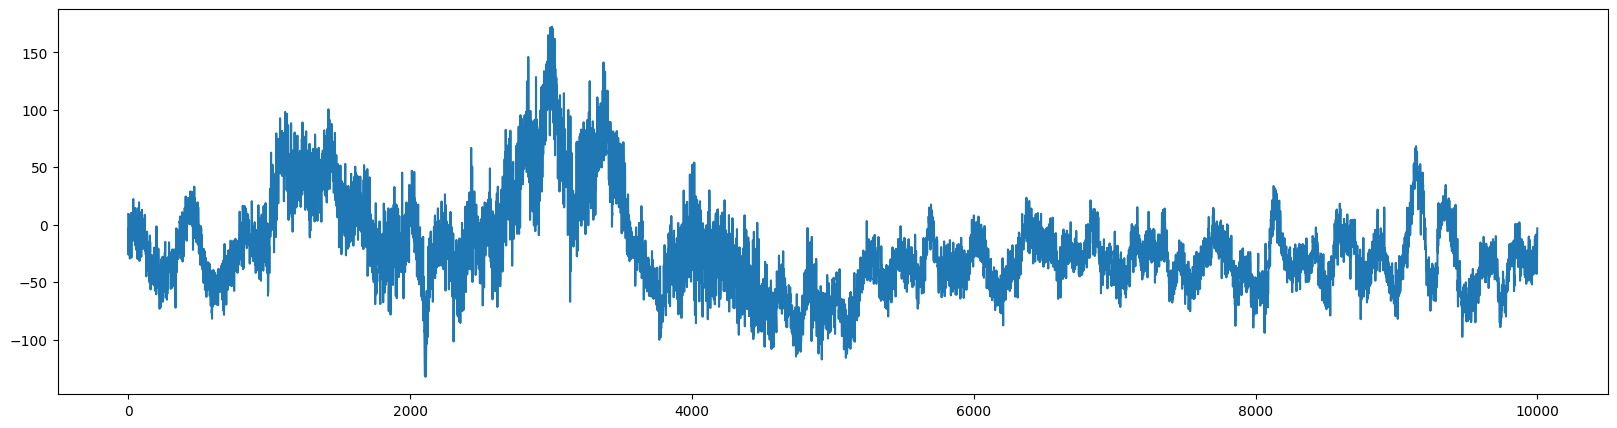

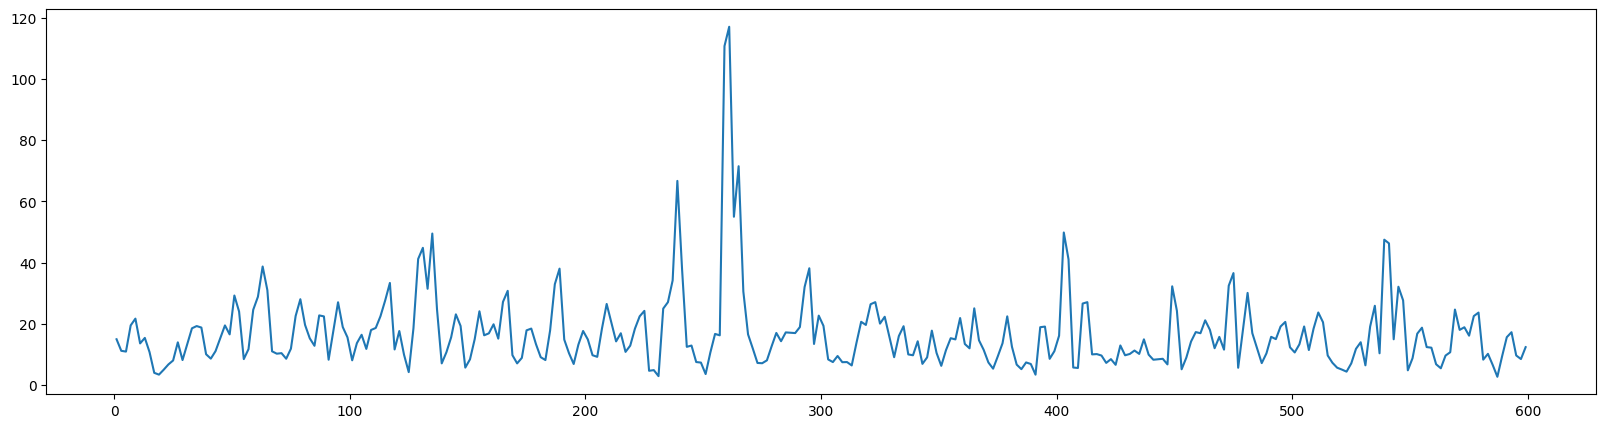

In [287]:
test_egg_id = 3911565283
test_spec_id = 853520

eeg_test = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/{test_egg_id}.parquet')    
plt.figure(figsize=(20,5))
plt.plot(eeg_test['Fp1'])

spec_test = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/{test_spec_id}.parquet')    
plt.figure(figsize=(20,5))
plt.plot(spec_test['time'], spec_test['LL_0.59'])

In [297]:
eeg_test_denoised = denoise(eeg_test, wavelet="db8")
eeg_test_denoised = eeg_test_denoised.iloc[4000:6000].mean().to_frame().T

eeg_test_scaled = rs.transform(eeg_test_denoised)

result = model.predict(eeg_test_scaled)
print(result)

1/1 [==============================] - 0s 25ms/step
[[0.05299229 0.19799837 0.10771119 0.08963179 0.29212433 0.25954202]]


In [296]:
submission[train_votes] = result
submission.to_csv('submission.csv')